Практическая работа:  
Трек ML-инженер  
Дополнительные главы Data Science  
DS-ADD-3. Байесовские методы в машинном обучении  
Мини-проект. Практика

Выполнил: Новиков Павел

# Задание
1. Сделать первичный анализ, подготовить признаки, которые будут использоваться и проанализируем их распределения.
Будем работать с целевой переменной, применив к ней логарифм

2. Сделаем модель байесовской линейной регрессии с выбранными признаками с библиотекой Bambi.  
**Bambi** — это высокоуровневый байесовский интерфейс построения моделей, написанный на Python. Он работает со структурой вероятностного программирования PyMC и разработан таким образом, чтобы чрезвычайно легко адаптировать байесовские модели смешанных эффектов, распространенные в биологии, социальных науках и других дисциплинах.

3. На тех же самых признаках построим линейную регрессию из sklearn и сравним получившиеся коэффициенты классической линейной регрессии с коэффициентами при признаках в байесовской линейной регрессии.  


In [ ]:
!pip install bambi -q
!pip install arviz -q

In [ ]:
import arviz as az
az.style.use("arviz-darkgrid")

SEED = 7355608

import bambi as bmb

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import warnings

import statsmodels.api as sm
import xarray as xr

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline, Pipeline

from scipy.special import expit as invlogit

# Disable a FutureWarning in ArviZ at the moment of running the notebook
az.style.use("arviz-darkgrid")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Загрузка данных

In [ ]:
#В колабе импортируем все необходимые библиотеки
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "1RpRtwakpYKYBRloszWUOUeiV31svfIyL"})
# https://drive.google.com/file/d/1RpRtwakpYKYBRloszWUOUeiV31svfIyL/view?usp=sharing
download.GetContentFile("flats.zip")

In [ ]:
raw_data = pd.read_csv('flats.zip', index_col = [0])

In [ ]:
raw_data.head(3)

,price_doc,full_sq,life_sq,num_room,kitch_sq
8056,2750000,11,11.0,1.0,12.0
8154,7100000,45,27.0,2.0,6.0
8287,11700000,77,50.0,3.0,8.0


# Подготовка данных

Этот набор данных содержит информацию о квартирах  
Ниже приводится описание переменных в наборе данных.

 - price_doc : Стоимость квартиры
 - full_sq : Общая площадь
 - life_sq: Жилая площадь
 - num_room : Количество комнат
 - kitch_sq : Площадь кухни

Сделаем первичный анализ, подготовим признаки, которые будете использовать и проанализируем их распределения.

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6042 entries, 8056 to 30470
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price_doc  6042 non-null   int64  
 1   full_sq    6042 non-null   int64  
 2   life_sq    6042 non-null   float64
 3   num_room   6042 non-null   float64
 4   kitch_sq   6042 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 283.2 KB


In [ ]:
raw_data.describe()

,price_doc,full_sq,life_sq,num_room,kitch_sq
count,6.042000e+03,6042.000000,6042.000000,6042.000000,6042.000000
mean,8.750423e+06,53.374545,33.198941,1.997021,7.391096
std,6.277290e+06,24.011941,20.190005,0.889523,3.806198
min,5.000000e+05,1.000000,0.000000,0.000000,0.000000
25%,5.800000e+06,38.000000,20.000000,1.000000,5.000000
50%,7.400000e+06,46.000000,29.000000,2.000000,7.000000
75%,1.050000e+07,63.000000,42.000000,3.000000,9.000000
max,9.512250e+07,637.000000,637.000000,17.000000,96.000000


## Удаление выбросов

In [ ]:
# Тьюки:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 3)
    upper_bound = quartile_3 + (iqr * 3)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

# data = pd.DataFrame(data)
outliers, cleaned = outliers_iqr(raw_data, 'life_sq')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 48
Результирующее число записей: 5994


In [ ]:
cleaned.describe()

,price_doc,full_sq,life_sq,num_room,kitch_sq
count,5.994000e+03,5994.000000,5994.000000,5994.000000,5994.000000
mean,8.576912e+06,52.486987,32.248582,1.983483,7.372372
std,5.749725e+06,20.605758,15.011257,0.865314,3.698031
min,5.000000e+05,1.000000,0.000000,0.000000,0.000000
25%,5.800000e+06,38.000000,20.000000,1.000000,5.000000
50%,7.350000e+06,46.000000,29.000000,2.000000,7.000000
75%,1.040000e+07,62.000000,41.000000,3.000000,9.000000
max,8.077744e+07,207.000000,108.000000,17.000000,96.000000


In [ ]:
data = cleaned.copy()

In [ ]:
#вывести нулевые значения
data[data.isnull().any(1)]

,price_doc,full_sq,life_sq,num_room,kitch_sq


Нулевых значений нет.

In [ ]:
data.head(3)

,price_doc,full_sq,life_sq,num_room,kitch_sq
8056,2750000,11,11.0,1.0,12.0
8154,7100000,45,27.0,2.0,6.0
8287,11700000,77,50.0,3.0,8.0


<Axes: >

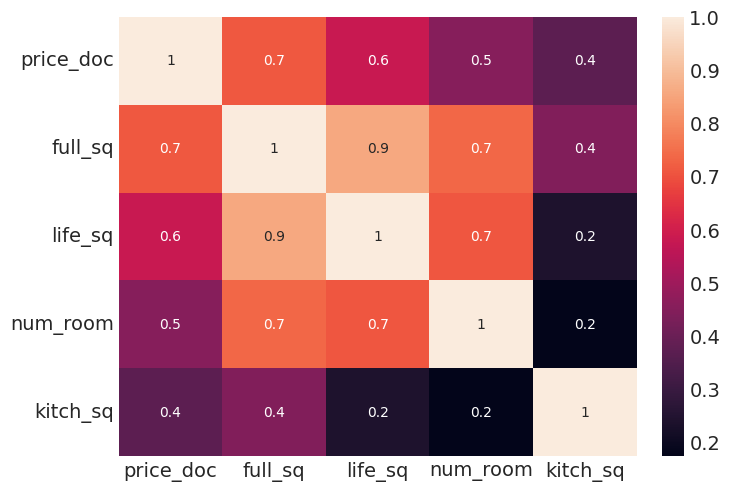

In [ ]:
# найдем наиболее скоррелированнные с целевым признаком признаки
h = data.corr()
sns.heatmap(h, annot = True, fmt='.1g')

life_sq сильно скоррелирован full_sq, но full_sq лучше скоррелирован с целевым признаком price_doc, поэтому удалим life_sq.

Посмотрим на распределения признаков

In [ ]:
# Just a utilitary function to truncate labels and avoid overlapping in plots
def truncate_labels(ticklabels, width=8):
    def truncate(label, width):
        if len(label) > width - 3:
            return label[0 : (width - 4)] + "..."
        else:
            return label

    labels = [x.get_text() for x in ticklabels]
    labels = [truncate(lbl, width) for lbl in labels]

    return labels

# Визуализация

<ipython-input-15-5e14ce500f34>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(truncate_labels(axes[1, 0].get_xticklabels()))
<ipython-input-15-5e14ce500f34>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(truncate_labels(axes[0, 1].get_xticklabels()))
<ipython-input-15-5e14ce500f34>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(truncate_labels(axes[0, 1].get_xticklabels()))
<ipython-input-15-5e14ce500f34>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2, 0].set_xticklabels(truncate_labels(axes[0, 1].get_xticklabels()))


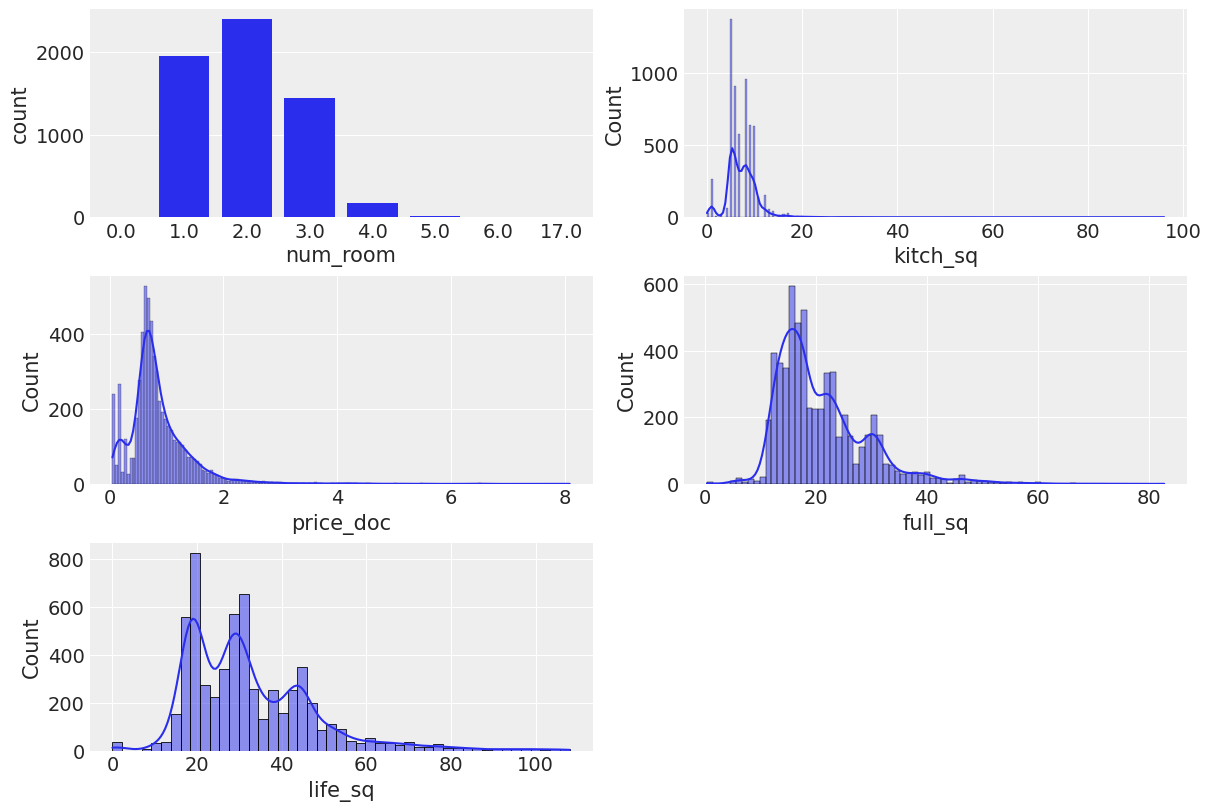

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
sns.countplot(data = data, x="num_room", ax=axes[0, 0], color="C0", saturation=1)
sns.histplot(data = data, x = "price_doc",ax=axes[1, 0], kde = True);
sns.histplot(data = data, x = "kitch_sq",ax=axes[0, 1], kde = True);
sns.histplot(data = data, x = "full_sq",ax=axes[1, 1], kde = True);
sns.histplot(data = data, x = "life_sq",ax=axes[2, 0], kde = True);
axes[1, 0].set_xlabel("price_doc")
axes[1, 0].set_ylabel("Count")
axes[1, 0].set_xticklabels(truncate_labels(axes[1, 0].get_xticklabels()))
axes[0, 1].set_xlabel("kitch_sq")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_xticklabels(truncate_labels(axes[0, 1].get_xticklabels()))
axes[1, 1].set_xlabel("full_sq")
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_xticklabels(truncate_labels(axes[0, 1].get_xticklabels()))
axes[2, 0].set_xlabel("life_sq")
axes[2, 0].set_ylabel("Count")
axes[2, 0].set_xticklabels(truncate_labels(axes[0, 1].get_xticklabels()))
axes[2, 1].axis('off');

Признаки явно не нормализованы, поэтому применим вначале нормализацию RobustScaler(), затем стандартизацию.

# Пайплайны


In [ ]:
from sklearn.compose import make_column_transformer
ct = make_column_transformer(
     (RobustScaler(), ['full_sq', 'kitch_sq', 'num_room']),
     (StandardScaler(), ['full_sq', 'kitch_sq', 'num_room'])
    )
print(ct)

ColumnTransformer(transformers=[('robustscaler', RobustScaler(),
                                 ['full_sq', 'kitch_sq', 'num_room']),
                                ('standardscaler', StandardScaler(),
                                 ['full_sq', 'kitch_sq', 'num_room'])])


In [ ]:
pipeline_lr = Pipeline([('ct', ct), ('lr', LinearRegression())])
pipeline_ard = Pipeline([('ct', ct), ('ard', ARDRegression())])
pipeline_br = Pipeline([('ct', ct), ('br', BayesianRidge())])

pipeline_ard.set_params(ard__compute_score=True,
                           ard__n_iter=30)

pipeline_br.set_params(br__compute_score=True,
                           br__n_iter=30)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['full_sq', 'kitch_sq',
                                                   'num_room']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['full_sq', 'kitch_sq',
                                                   'num_room'])])),
                ('br', BayesianRidge(compute_score=True, n_iter=30))])

# Формирование моделей и вывод метрик

In [ ]:
# логарифмируем целевой признак
data.loc[:,'price_doc'] = data.loc[:,'price_doc'].apply(lambda x: np.log(x))

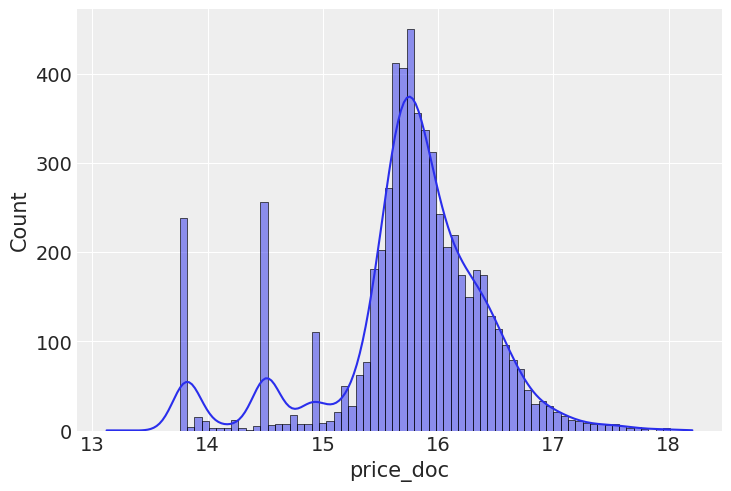

In [ ]:
sns.histplot(data = data, x = "price_doc", kde = True);

Распределение после логарифмирования имеет признаки нормального, но лучше провести тест.

In [ ]:
data['price_doc'].describe()

count    5994.000000
mean       15.763687
std         0.683258
min        13.122363
25%        15.573368
50%        15.810211
75%        16.157316
max        18.207208
Name: price_doc, dtype: float64

In [ ]:
import scipy.stats as stats

def test_shapiro(data, alpha = 0.05):
  # проводим тест Шапиро — Уилка
  _, p = stats.shapiro(data)
  print('p-value = %.3f' % (p))
  # интерпретируем результат
  if p <= alpha:
      print('Распределение не нормальное')
  else:
      print('Распределение нормальное')

test_shapiro(data['price_doc'])

p-value = 0.000
Распределение не нормальное


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
X = data.loc[:, ~data.columns.isin(['price_doc', 'life_sq'])]
y = data['price_doc'].values

In [ ]:
X.sample(3)

,full_sq,num_room,kitch_sq
20091,46,2.0,6.0
12336,35,1.0,5.0
9931,45,2.0,6.0


Разделим выборку на тренинговую и тестовую часть

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
print(f'Размер обучающей выборки {X_train.shape}')
print(f'Размер тестовой выборки {X_test.shape}')

Размер обучающей выборки (4495, 3)
Размер тестовой выборки (1499, 3)


In [ ]:
pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)
lr_mse = round(mean_squared_error(y_test, y_pred),8)
print(f'Качество lr по MSE: {lr_mse}')

pipeline_ard.fit(X_train, y_train)
y_pred = pipeline_ard.predict(X_test)
ard_mse = round(mean_squared_error(y_test, y_pred),8)
print(f'Качество ard по MSE: {ard_mse}')

pipeline_br.fit(X_train, y_train)
y_pred = pipeline_br.predict(X_test)
br_mse = round(mean_squared_error(y_test, y_pred),8)
print(f'Качество br по MSE: {br_mse}')

Качество lr по MSE: 0.34293031
Качество ard по MSE: 0.34287442
Качество br по MSE: 0.3428547


# Линейная регрессия с байесовским подходом

## Создадим модель и изучим априоры

In [ ]:
model = bmb.Model("price_doc ~  full_sq + num_room + kitch_sq", data)
# fitted = model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=SEED)
fitted = model.fit(tune=2000, draws=2000, random_seed=SEED)

Если пользователь явно не задает априорные значения, то Bembi выбирает умные априорные значения по умолчанию для всех параметров модели на основе подразумеваемых частичных корреляций между результатом и предикторами.  
Модель подстраивается под фактическое распределение данных.  
 Вот как в этом случае выглядят априорные значения по умолчанию — графики ниже показывают 1000 выборок из каждого априорного распределения:

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


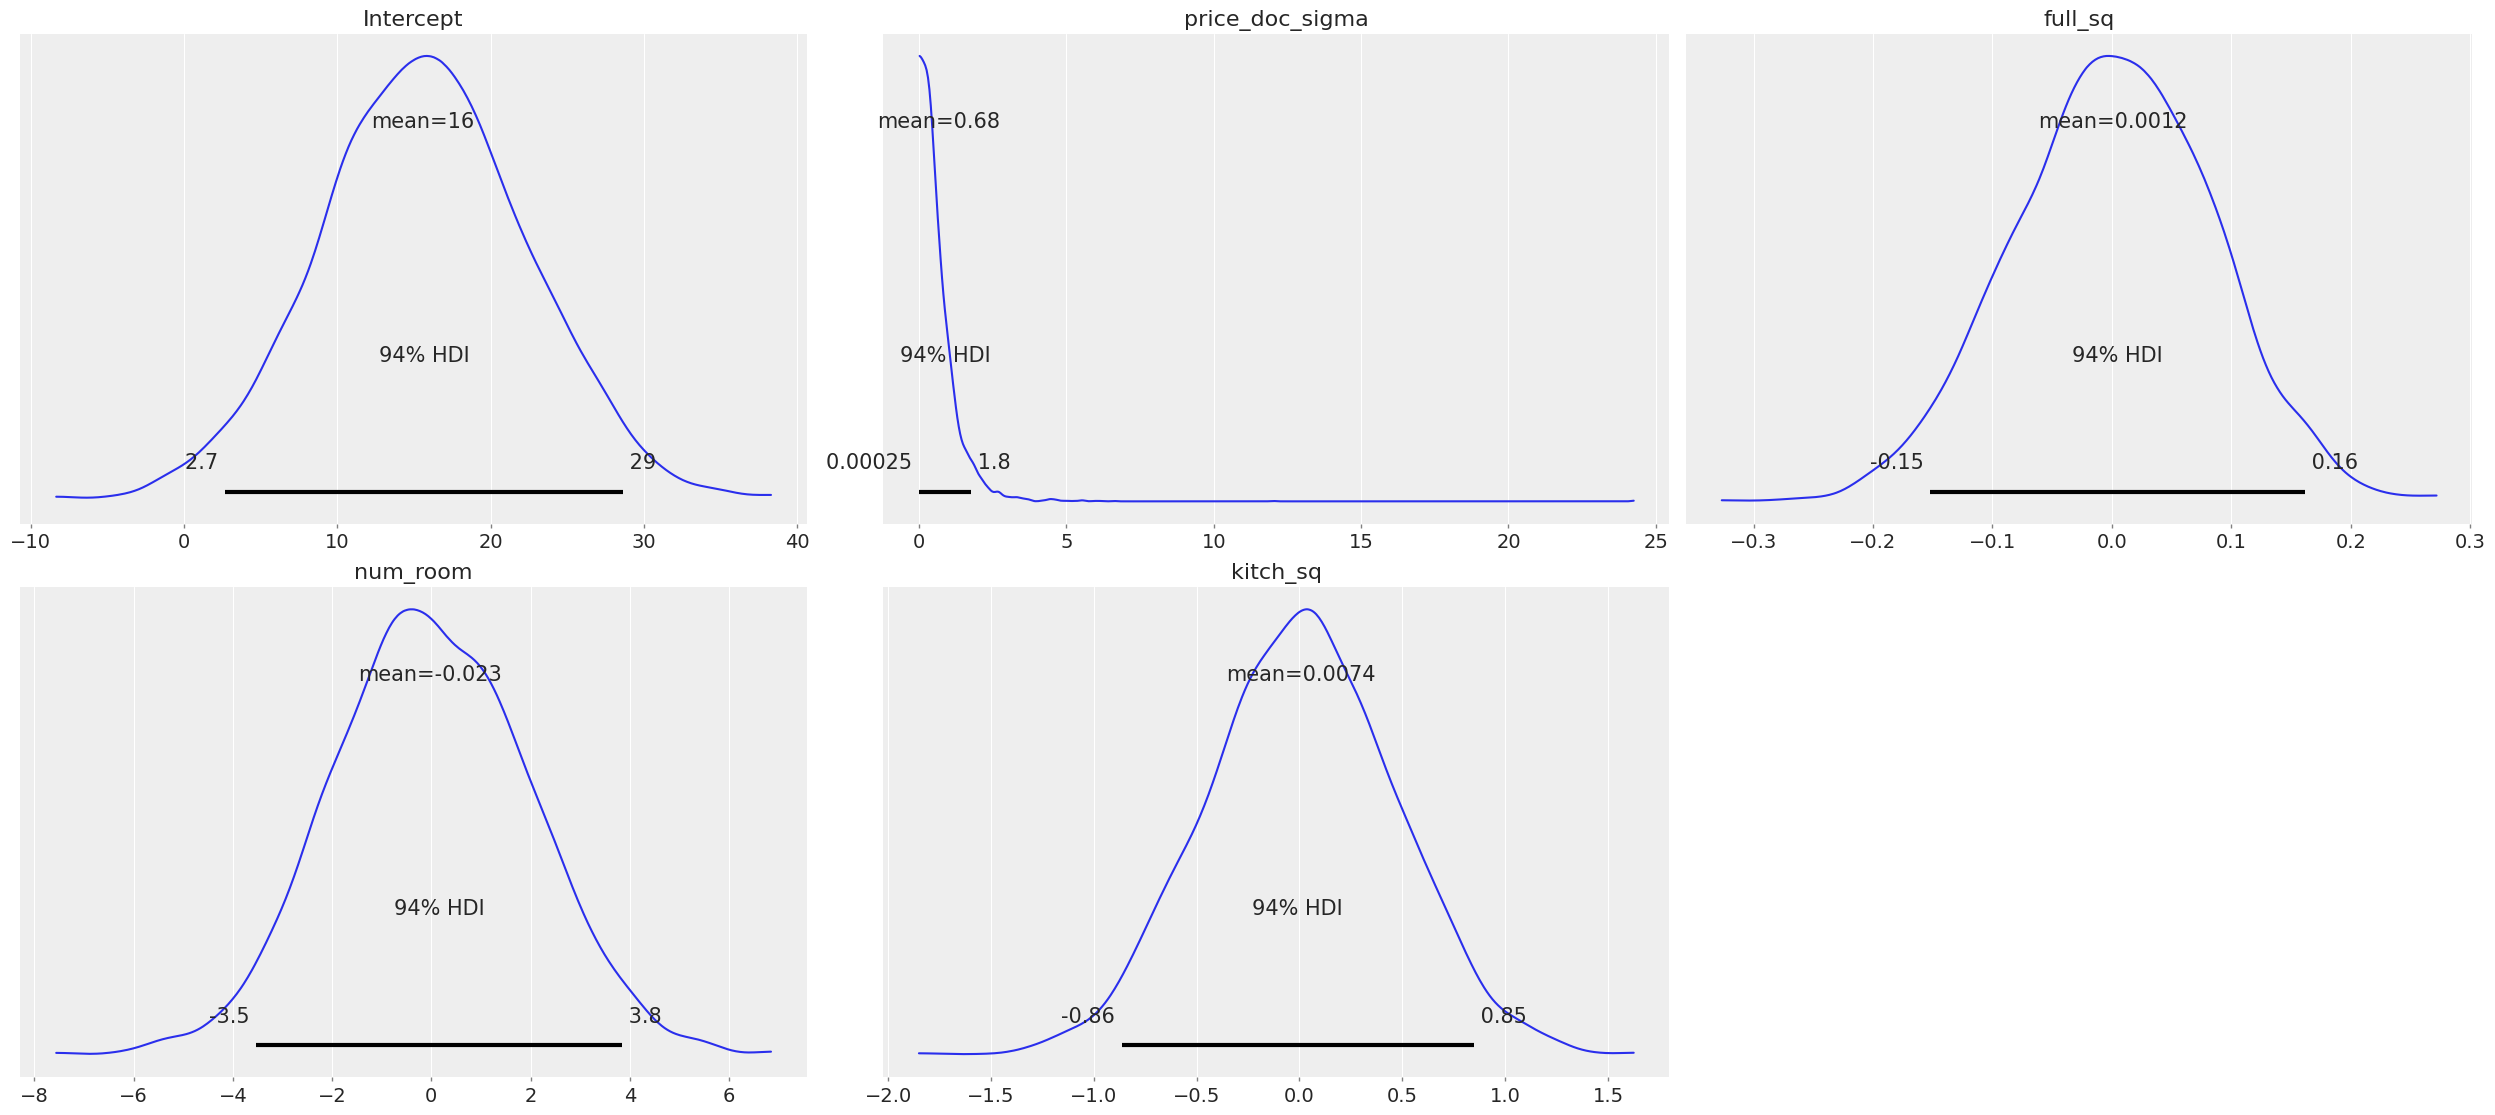

In [ ]:
model.plot_priors();

In [ ]:
# Нормальные приоры для коэффицентов
{x.name: x.prior.args for x in model.response_component.terms.values()}

{'Intercept': {'mu': array(15.76368654), 'sigma': array(6.98393461)},
 'full_sq': {'mu': array(0.), 'sigma': array(0.08289647)},
 'num_room': {'mu': array(0.), 'sigma': array(1.97401785)},
 'kitch_sq': {'mu': array(0.), 'sigma': array(0.46190653)},
 'price_doc': {'mu': array(0.), 'sigma': array(1.)}}

В данном представлении показаны распределения коэффицентов модели, т.к. модель носит вероятностный характер

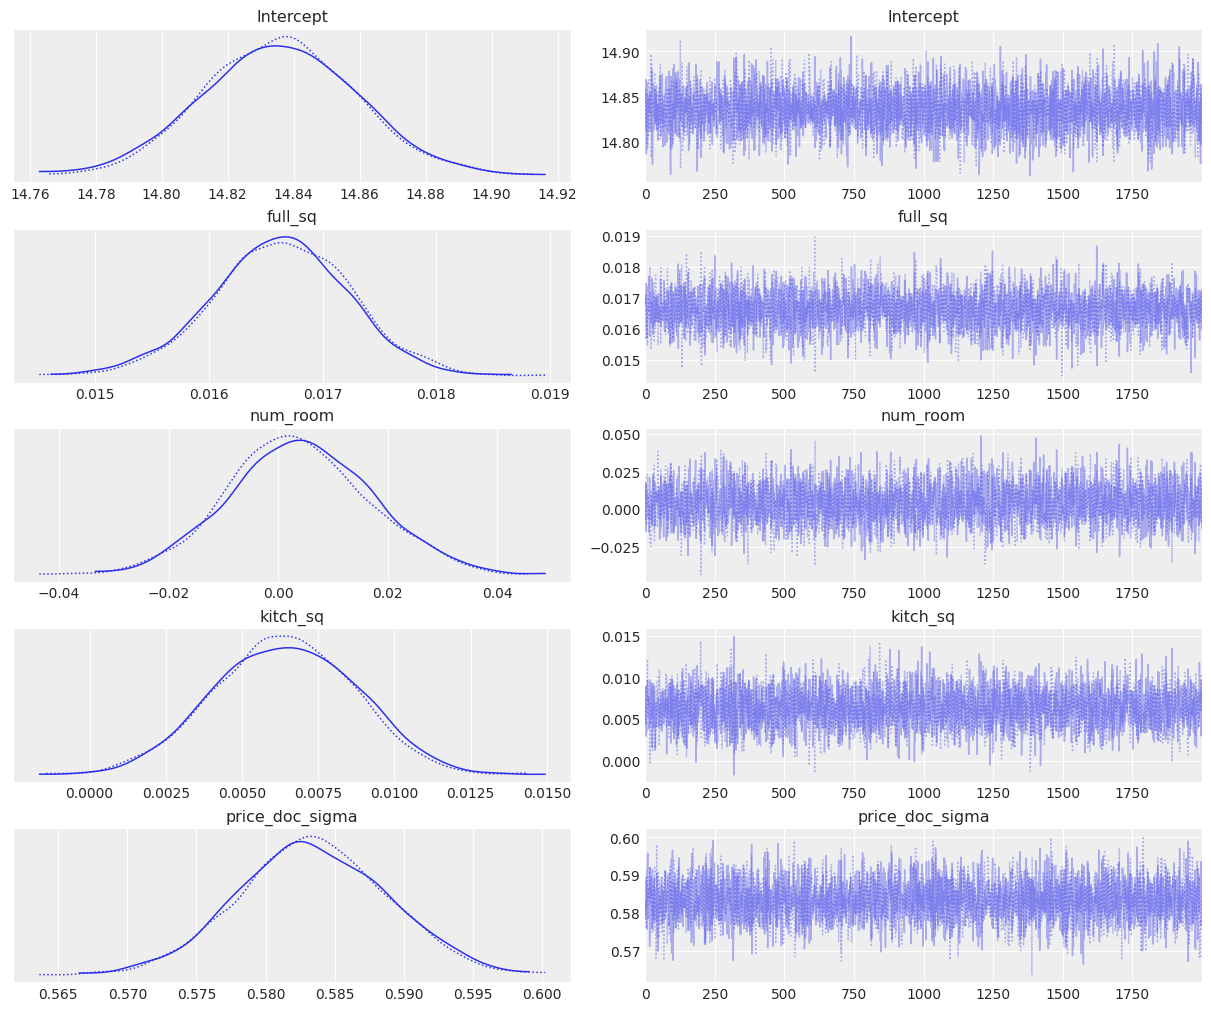

In [ ]:
az.plot_trace(fitted);

На левых панелях показаны предельные апостериорные распределения для всех параметров модели, которые суммируют наиболее правдоподобные значения коэффициентов регрессии, учитывая данные, которые мы сейчас наблюдаем.   
Эти графики апостериорной плотности показывают два наложенных распределения, поскольку мы использовали две цепи MCMC.  
Панели справа представляют собой «графики трассировки», показывающие пути выборки двух цепочек MCMC, когда они блуждают по пространству параметров.
Если бы какой-либо из этих путей демонстрировал картину, отличную от белого шума, мы были бы обеспокоены сходимостью цепочек.   
Но здесь все штатно.

Гораздо более сжатую (неграфическую) сводку оценок параметров можно найти так:



In [ ]:
az.summary(fitted)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,14.836,0.023,14.793,14.880,0.0,0.0,4741.0,3139.0,1.0
full_sq,0.017,0.001,0.016,0.018,0.0,0.0,3442.0,2913.0,1.0
num_room,0.004,0.013,-0.020,0.029,0.0,0.0,3766.0,3336.0,1.0
kitch_sq,0.006,0.002,0.002,0.011,0.0,0.0,4355.0,3256.0,1.0
price_doc_sigma,0.583,0.005,0.573,0.593,0.0,0.0,4533.0,2740.0,1.0


При наличии нескольких цепочек MCMC сводный вывод по умолчанию включает некоторую базовую диагностическую информацию о конвергенции (эффективные размеры выборки MCMC и статистику «R-шляпы» Гельмана-Рубина), хотя в этом случае из приведенных выше графиков трассировки довольно ясно, что цепи сошлись просто отлично.

# Суммируем эффекты по шкале частичной корреляции

In [ ]:
samples = fitted.posterior

Добавим данные о апостериорной вероятности модели

In [ ]:
posterior_predictive = model.predict(fitted, kind="pps")

Визуализируем полученные вероятности прогнозирования целевого признака.

<Axes: xlabel='price_doc / price_doc'>

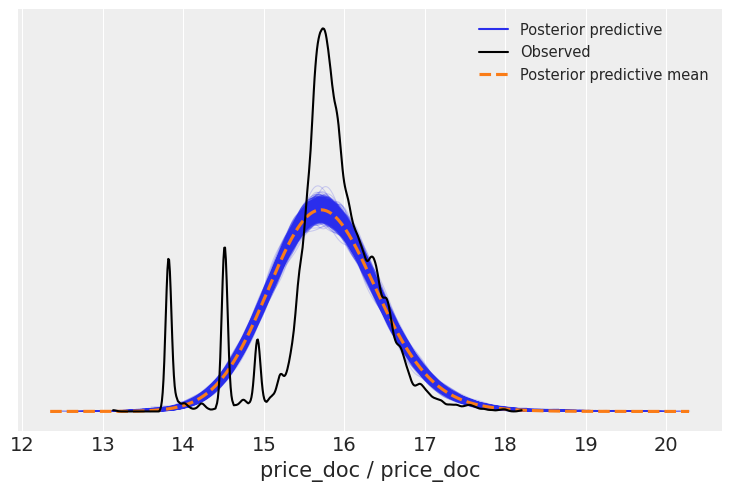

In [ ]:
az.plot_ppc(fitted)

# Сравнение коэффицентов

Составим сводную таблицу результатов исследования

In [ ]:
bambi_coeff = az.summary(fitted)['mean'][:7]
bambi_coeff

Intercept            14.836
full_sq               0.017
num_room              0.004
kitch_sq              0.006
price_doc_sigma       0.583
price_doc_mean[0]    15.099
price_doc_mean[1]    15.630
Name: mean, dtype: float64

In [ ]:
X_pred = bambi_coeff[0] + X_test['full_sq']*bambi_coeff[1] + X_test['num_room']*bambi_coeff[2] + X_test['kitch_sq']*bambi_coeff[3]
bambi_mse = round(mean_squared_error(y_test, y_pred),8)
print(f'Качество bambi по MSE: {bambi_mse}')

Качество bambi по MSE: 0.3428547


In [ ]:
regression_coeff = bambi_coeff.index[0:5]

In [ ]:

df_coef = pd.DataFrame(
    {
        "ARDRegression": pipeline_ard['ard'].coef_,
        "BayesianRidge": pipeline_br['br'].coef_,
        "LinearRegression": pipeline_lr['lr'].coef_,
        "Bambi" : bambi_coeff[1:]
    }
)

df_intercept = pd.DataFrame(
    {
        "ARDRegression": pipeline_ard['ard'].intercept_,
        "BayesianRidge": pipeline_br['br'].intercept_,
        "LinearRegression": pipeline_lr['lr'].intercept_,
        "Bambi" : bambi_coeff[0]
    }, index = [0]
)

df_metrics = pd.DataFrame(
    {
        "ARDRegression": ard_mse,
        "BayesianRidge": br_mse,
        "LinearRegression": lr_mse,
        "Bambi" : bambi_mse
    }, index = ['mse_metrics']
)

df = pd.concat([df_intercept, df_coef, df_metrics]).reset_index(drop = True)[:5].set_index(regression_coeff)
df1 = pd.concat([df, df_metrics])
df1.head(10)

,ARDRegression,BayesianRidge,LinearRegression,Bambi
Intercept,15.717295,15.718166,8.861933e+11,14.836000
full_sq,0.171322,0.167174,-3.176253e+12,0.017000
num_room,0.008212,0.011083,-3.802413e+11,0.004000
kitch_sq,0.000000,0.002752,-5.985960e+11,0.006000
price_doc_sigma,0.199455,0.194640,2.728057e+12,0.583000
mse_metrics,0.342874,0.342855,3.429303e-01,0.342855


Исходя из полученных данных можно увидеть существенные различия в коэффицентах обычных и байесовских моделей.   
При этом качество прогнозирования заметно не меняется.
Однако, формально метрики MSE у моделей Bambi и BayesianRidge наиболее низкие.